<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Exercise-09" data-toc-modified-id="Exercise-09-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Exercise 09</a></span><ul class="toc-item"><li><span><a href="#Sequence-Classification-using-LSTM" data-toc-modified-id="Sequence-Classification-using-LSTM-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Sequence Classification using LSTM</a></span><ul class="toc-item"><li><span><a href="#Word-Embedding" data-toc-modified-id="Word-Embedding-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Word Embedding</a></span></li></ul></li></ul></li><li><span><a href="#Exercise-09.1" data-toc-modified-id="Exercise-09.1-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Exercise 09.1</a></span></li><li><span><a href="#Exercise-09.2" data-toc-modified-id="Exercise-09.2-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Exercise 09.2</a></span></li></ul></div>

# Exercise 09

**Integrante 1:** Ángela Patricia Ordoñez Castro...................................................**Código:** 201628709     
**Integrante 2:** Juan Sebastián Garcés Carranza.................................................**Código:** 201628949 

## Sequence Classification using LSTM

Sequence classification is a predictive modeling problem where you have some sequence of inputs over space or time and the task is to predict a category for the sequence.

What makes this problem difficult is that the sequences can vary in length, be comprised of a very large vocabulary of input symbols and may require the model to learn the long-term context or dependencies between symbols in the input sequence.

[The Large Movie Review Dataset](http://ai.stanford.edu/~amaas/data/sentiment/) (often referred to as the IMDB dataset) contains 25,000 highly-polar movie reviews (good or bad) for training and the same amount again for testing. The problem is to determine whether a given movie review has a positive or negative sentiment.

In [1]:
import numpy as np
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import History
np.random.seed(7)

/Users/JUANGARCESC/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from livelossplot import PlotLossesKeras
%matplotlib inline

In [3]:
# load the dataset but only keep the top n words, zero the rest
top_words = 5000
index_from = 3
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words, index_from=index_from)

In [4]:
y_train[0]

1

In [5]:
np.min([np.min(x) for x in X_train]), np.max([np.max(x) for x in X_train])

(1, 4999)

The words have been replaced by integers that indicate the ordered frequency of each word in the dataset. The sentences in each review are therefore comprised of a sequence of integers.

In [6]:
X_train.shape

(25000,)

In [7]:
print(X_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 2, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 2, 19, 178, 32]


Next, we need to truncate and pad the input sequences so that they are all the same length for modeling. The model will learn the zero values carry no information so indeed the sequences are not the same length in terms of content, but same length vectors is required to perform the computation in Keras.

In [8]:
# truncate and pad input sequences
max_review_length = 500
X_train_pad = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test_pad = sequence.pad_sequences(X_test, maxlen=max_review_length)

In [9]:
X_train_pad.shape

(25000, 500)

### Word Embedding

We will map each movie review into a real vector domain, a popular technique when working with text called word embedding. This is a technique where words are encoded as real-valued vectors in a high dimensional space, where the similarity between words in terms of meaning translates to closeness in the vector space.

Keras provides a convenient way to convert positive integer representations of words into a word embedding by an Embedding layer.

We will map each word onto a 32 length real valued vector. We will also limit the total number of words that we are interested in modeling to the 5000 most frequent words, and zero out the rest. Finally, the sequence length (number of words) in each review varies, so we will constrain each review to be 500 words, truncating long reviews and pad the shorter reviews with zero values.

Now that we have defined our problem and how the data will be prepared and modeled, we are ready to develop an LSTM model to classify the sentiment of movie reviews.

# Exercise 09.1

Train a Deep Neural Network with the following architecture:

- Input = pad_sequences (input_length=max_review_length)
- Embedding(top_words, 32, input_length)
- LSTM(100)
- Dense(1, sigmoid)

Optimized using adam using as loss binary_crossentropy

Hints: 
- test with two iterations then try more. 
- learning can be ajusted

Evaluate the performance using the testing set (aprox 87% with 10 epochs)

In [10]:
from keras.optimizers import Adam

model = Sequential()

model.add(Embedding(top_words+1, 32, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', metrics=['accuracy'],
              optimizer=Adam(lr=0.0008))

model.summary()   

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           160032    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 213,333
Trainable params: 213,333
Non-trainable params: 0
_________________________________________________________________


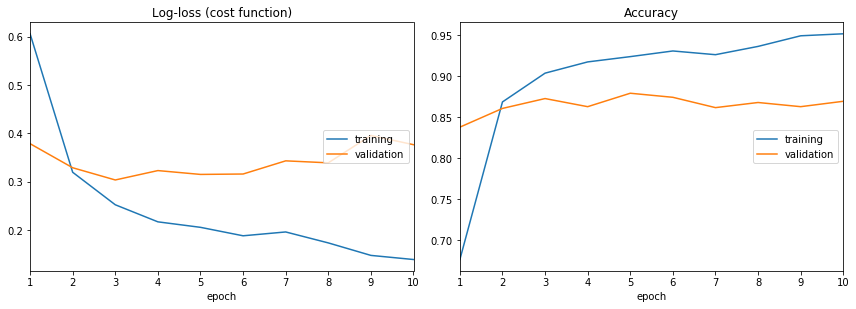

In [11]:
model.fit(X_train_pad, y_train, validation_data=[X_test_pad, y_test], 
          batch_size=128, epochs=10, verbose=1,
          callbacks=[PlotLossesKeras()])

In [12]:
score = model.evaluate(X_test_pad, y_test)
print('Test accuracy:', score[1])

25000/25000 [==============================] - 84s 3ms/step
Test accuracy: 0.86912


# Exercise 09.2

Predict the sentiment of the following reviews

In [13]:
reviews = ["I was fortunate enough to see this movie on pre-release last night and, though I wasn't expecting to, actually really enjoyed the movie for the most part. The rescues and sea effects were amazing to watch and definitely provided edge of the seat tense moments, probably all the more so knowing that there are guys who do this for a living. The weaker parts of the movie revolve largely around using stereotypical set scenes. I'm not going to spoil the movie but this really follows along the lines of An Officer and a Gentleman and those moments give it a little bit of a cheesy aftertaste.<br /><br />Like I said over all this movie is pretty good and worth checking out as long as you can get past the clichés.",
           '"The Dresser" is perhaps the most refined of backstage films. The film is brimming with wit and spirit, for the most part provided by the "energetic" character of Norman (Tom Courtenay). Although his character is clearly gay, and certainly has an attraction for the lead performer (Albert Finney) that he assists, the film never dwells on it or makes it more than it is.<br /><br />The gritty style of Peter Yates that worked so well in "Bullitt" is again on display, and gives the film a sense of realism and coherence. This is much appreciated in a story that could so easily have become tedious. In the end, "The Dresser" will bore many people silly, but it will truly be a delight to those who love British cinema.<br /><br />7.7 out of 10',
           "So real and surreal, all in one. I remember feeling like Tessa. Heck, I remember being Tessa. This was a beautiful vignette of a relationship ending. I especially liked the protesters tangent. It is nice to see symbolism in a movie without being smacked over the head with it. If you get the chance to see this, take it. It is well worth the 30 minutes.",
           "This is a pale imitation of 'Officer and a Gentleman.' There is NO chemistry between Kutcher and the unknown woman who plays his love interest. The dialog is wooden, the situations hackneyed. It's too long and the climax is anti-climactic(!). I love the USCG, its men and women are fearless and tough. The action scenes are awesome, but this movie doesn't do much for recruiting, I fear. The script is formulaic, but confusing. Kutcher's character is trying to redeem himself for an accident that wasn't his fault? Costner's is raging against the dying of the light, but why? His 'conflict' with his wife is about as deep as a mud puddle. I saw this sneak preview for free and certainly felt I got my money's worth.",
           "I was at Wrestlemania VI in Toronto as a 10 year old, and the event I saw then was pretty different from what I saw on the Wrestlemania Collection DVD I just watched. I don't understand how the wwE doesn't have the rights to some of the old music, since most of those songs were created by the WWF they shouldn't have to worry about the licensing and royalty fees that prevent shows like SNL from releasing season sets. Its pretty stupid to whine about, but for me hearing Demolition come out to their theme music at a Wrestlemania in person was a memory that I never forgot, and it didn't exist on this DVD. What is the point of them even owning the rights to this huge library of video if they have to edit it so drastically to use it?",
           "Wow! What a movie if you want to blow your budget on the title and have it look real bad ask the guys that made this movie on how to do that. They could have spent the money on a good rewrite or something else. Or they could have spent it on beer when they made this movie at least it would have come out better."
          ]

Reviews must be preprocessed

In [14]:
from keras.datasets.imdb import get_word_index

vocab = get_word_index()

vocab = {k:(v+index_from) for k,v in vocab.items()}
vocab["<PAD>"] = 0
vocab["<START>"] = 1
vocab["<UNK>"] = 2

In [15]:
{k:vocab[k] for k in list(vocab.keys())[:10]}

{'fawn': 34704,
 'tsukino': 52009,
 'nunnery': 52010,
 'sonja': 16819,
 'vani': 63954,
 'woods': 1411,
 'spiders': 16118,
 'hanging': 2348,
 'woody': 2292,
 'trawling': 52011}

 Lets see how X_train is encoded

In [16]:
print(X_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 2, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 2, 19, 178, 32]


Lets get the text

In [17]:
id_to_word = {value:key for key,value in vocab.items()}
print(' '.join(id_to_word[id] for id in X_train[0] ))

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly <UNK> was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little <UNK> that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big <UNK> for the whole film but these children are amazing and should be <UNK> for what they

Compared with the original review in lowercase:

"this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you think the whole story was so lovely because it was true and was someone's life after all that was shared with us all"

In [18]:
X_review = [[vocab[x1] for x1 in x if x1 in vocab.keys()] for x in reviews]
X_review_pad = sequence.pad_sequences(X_review, maxlen=max_review_length)
X_review_pad[X_review_pad>5000]=2
X_review_pad

array([[2023, 1604, 1206, ..., 1148, 2023,  590],
       [1479,   13, 1983, ..., 1209,  300, 2241],
       [   0,    0,    0, ...,  830,  963,  590],
       [1148, 2023,  963, ..., 1479,  830, 2023],
       [ 963,  830,  830, ...,  963,   13,  830],
       [   0,    0,    0, ...,  830,  963, 1479]], dtype=int32)

In [19]:
model.predict(X_review_pad)

array([[0.0087481 ],
       [0.5596215 ],
       [0.00174471],
       [0.00875673],
       [0.00424855],
       [0.00393096]], dtype=float32)

De acuerdo con la predicción del modelo, la segunda reseña de la película es la única positiva (dado que es mayor a 0.5), las demás reseñas son negativas.